# Setup

In [2]:
# import dependencies
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

from datetime import datetime
from scipy.optimize import minimize

from models import FuturePrices
from estimation import ParameterEstimation

In [3]:
futures = FuturePrices()
par = ParameterEstimation(method=None, tolerance=float(1e-10))

In [4]:
# import data
df_param_non_covid = pd.read_csv('results/param_non_covid.csv', sep=';', index_col=0)
df_param_covid = pd.read_csv('results/param_covid.csv', sep=';', index_col=0)
df_non_covid = pd.read_csv('results/non_covid.csv', sep=';', index_col='tradingDay')
df_covid = pd.read_csv('results/covid.csv', sep=';', index_col='tradingDay')
df = pd.read_csv('data_clean/all_data_clean_return_rate.csv', sep=';', index_col='tradingDay')

In [5]:
# include cutoff point
cutoff = '2016-05-01'
covid_cutoff = '2020-01-01'
df_param_non_covid = df_param_non_covid.loc[df_param_non_covid.index >= cutoff]
df_param_covid = df_param_covid.loc[df_param_covid.index >= cutoff]
df = df.loc[df.index >= cutoff]

In [6]:
# include estimates
estimates_non_covid = {'alpha': 55.5157, 'kappa': 0.6108}
estimates_covid = {'alpha': 51.1674, 'kappa': 0.4057}

# EDA

## Futures contract prices

In [7]:
df['future'].describe()

count    119884.000000
mean         52.668348
std           5.733347
min         -14.000000
25%          50.380000
50%          52.800000
75%          55.190000
max          84.390000
Name: future, dtype: float64

## WTI spot prices

Text(0, 0.5, 'price ($/barrel)')

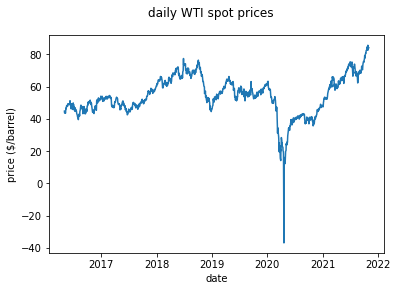

In [9]:
# axis
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[df['symbol']=='CLZ21', 'spot'].index)]
spot = df.loc[df['symbol']=='CLZ21', 'spot'].to_numpy()
# layout
fig.suptitle('daily WTI spot prices')
graph = plt.plot(dates, spot)
plt.xlabel('date')
plt.ylabel('price ($/barrel)')

## Interest rate

Our interest rate is 1.15%

In [11]:
df.iloc[0]['r']

0.0115396995708154

# Price estimation

### Non-Covid period

In [12]:
# for bachalier model
F_hat_bachelier = futures.bachelier(df.loc[df.index < covid_cutoff,'spot'].to_numpy().astype(float), df.loc[df.index < covid_cutoff,'S0'].to_numpy().astype(float), df.loc[df.index < covid_cutoff,'r'].to_numpy().astype(float), df.loc[df.index < covid_cutoff,'tau'].to_numpy().astype(float))
df.loc[df.index < covid_cutoff, 'F_hat_bachelier'] = F_hat_bachelier

# for arithmetic mean reversion model
F_hat_AMR = futures.arithmetic_MR(df.loc[df.index < covid_cutoff,'spot'].to_numpy().astype(float), df.loc[df.index < covid_cutoff,'r'].to_numpy().astype(float), df.loc[df.index < covid_cutoff,'tau'].to_numpy().astype(float), estimates_non_covid['alpha'], estimates_non_covid['kappa'])
df.loc[df.index < covid_cutoff, 'F_hat_AMR'] = F_hat_AMR
    

### Covid period

In [13]:
# for bachalier model
F_hat_bachelier = futures.bachelier(df.loc[df.index >= covid_cutoff,'spot'].to_numpy().astype(float), df.loc[df.index >= covid_cutoff,'S0'].to_numpy().astype(float), df.loc[df.index >= covid_cutoff,'r'].to_numpy().astype(float), df.loc[df.index >= covid_cutoff,'tau'].to_numpy().astype(float))
df.loc[df.index >= covid_cutoff, 'F_hat_bachelier'] = F_hat_bachelier

# for arithmetic mean reversion model
F_hat_AMR = futures.arithmetic_MR(df.loc[df.index >= covid_cutoff,'spot'].to_numpy().astype(float), df.loc[df.index >= covid_cutoff,'r'].to_numpy().astype(float), df.loc[df.index >= covid_cutoff,'tau'].to_numpy().astype(float), estimates_covid['alpha'], estimates_covid['kappa'])
df.loc[df.index >= covid_cutoff, 'F_hat_AMR'] = F_hat_AMR
    

Text(0, 0.5, 'price ($)')

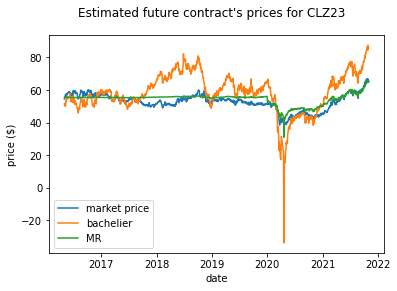

In [72]:
# axis
symbol = 'CLZ23'
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[(df['symbol'] == symbol)].index)]
future = df.loc[(df['symbol'] == symbol), 'future'].to_numpy()
bachelier = df.loc[(df['symbol'] == symbol), 'F_hat_bachelier'].to_numpy()
AMR = df.loc[(df['symbol'] == symbol), 'F_hat_AMR'].to_numpy()
# layout
fig.suptitle("Estimated future contract's prices for {}".format(symbol))
plt.plot(dates, future, label='market price', color='tab:blue')
plt.plot(dates, bachelier, label='bachelier', color='tab:orange')
plt.plot(dates, AMR, label='MR', color='tab:green')
plt.legend()
plt.xlabel('date')
plt.ylabel("price ($)")

Text(0, 0.5, 'price ($)')

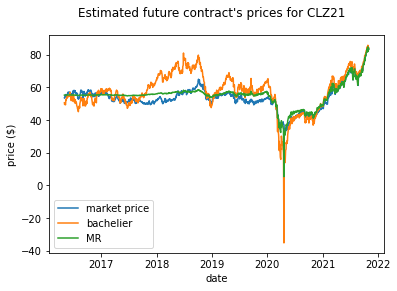

In [73]:
# axis
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[(df['symbol'] == symbol)].index)]
future = df.loc[(df['symbol'] == 'CLZ21'), 'future'].to_numpy()
bachelier = df.loc[(df['symbol'] == 'CLZ21'), 'F_hat_bachelier'].to_numpy()
AMR = df.loc[(df['symbol'] == 'CLZ21'), 'F_hat_AMR'].to_numpy()
# layout
fig.suptitle("Estimated future contract's prices for CLZ21")
plt.plot(dates, future, label='market price', color='tab:blue')
plt.plot(dates, bachelier, label='bachelier', color='tab:orange')
plt.plot(dates, AMR, label='MR', color='tab:green')
plt.legend()
plt.xlabel('date')
plt.ylabel("price ($)")

Text(0, 0.5, 'price ($)')

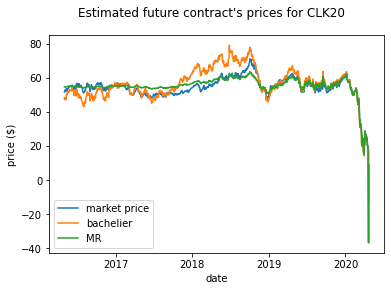

In [74]:
# axis
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[(df['symbol'] == 'CLK20')].index)]
future = df.loc[(df['symbol'] == 'CLK20'), 'future'].to_numpy()
bachelier = df.loc[(df['symbol'] == 'CLK20'), 'F_hat_bachelier'].to_numpy()
AMR = df.loc[(df['symbol'] == 'CLK20'), 'F_hat_AMR'].to_numpy()
# layout
fig.suptitle("Estimated future contract's prices for CLK20")
plt.plot(dates, future, label='market price', color='tab:blue')
plt.plot(dates, bachelier, label='bachelier', color='tab:orange')
plt.plot(dates, AMR, label='MR', color='tab:green')
plt.legend()
plt.xlabel('date')
plt.ylabel("price ($)")

Text(0, 0.5, 'price ($)')

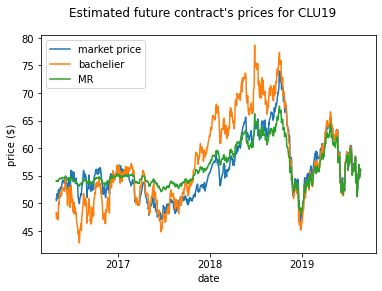

In [75]:
# axis
symbol = 'CLU19'
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[(df['symbol'] == symbol)].index)]
future = df.loc[(df['symbol'] == symbol), 'future'].to_numpy()
bachelier = df.loc[(df['symbol'] == symbol), 'F_hat_bachelier'].to_numpy()
AMR = df.loc[(df['symbol'] == symbol), 'F_hat_AMR'].to_numpy()
# layout
fig.suptitle("Estimated future contract's prices for {}".format(symbol))
plt.plot(dates, future, label='market price', color='tab:blue')
plt.plot(dates, bachelier, label='bachelier', color='tab:orange')
plt.plot(dates, AMR, label='MR', color='tab:green')
plt.legend()
plt.xlabel('date')
plt.ylabel("price ($)")

# Residuals

In [18]:
# calculate pricing errors
df.loc[:,'error_bachelier'] = abs(df.loc[:,'future'] - df.loc[:,'F_hat_bachelier'])
df.loc[:,'error_AMR'] = abs(df.loc[:,'future'] - df.loc[:,'F_hat_AMR'])

## Descriptive statistics

### Non-Covid

In [34]:
df[['error_bachelier', 'error_AMR']].loc[df.index < covid_cutoff].describe()

,error_bachelier,error_AMR
count,81020.000000,81020.000000
mean,6.960661,2.243912
std,6.055408,1.519449
min,0.000000,0.000000
25%,1.924581,0.975895
50%,5.248307,1.965121
75%,10.506468,3.447311
max,29.085048,8.014939


In [68]:
df[['error_bachelier', 'error_AMR']].loc[df.index < covid_cutoff].sum()

error_bachelier    563952.733060
error_AMR          181801.757372
dtype: float64

### Covid

In [35]:
df[['error_bachelier', 'error_AMR']].loc[df.index >= covid_cutoff].describe()

,error_bachelier,error_AMR
count,38864.000000,38864.000000
mean,9.112297,2.205519
std,7.996498,2.116262
min,0.000926,0.000070
25%,2.533722,0.663652
50%,6.993884,1.696547
75%,14.386893,3.421044
max,81.131129,60.268749


In [69]:
df[['error_bachelier', 'error_AMR']].loc[df.index >= covid_cutoff].sum()

error_bachelier    354140.295082
error_AMR           85715.294872
dtype: float64

## Distribution of errors

### Non-Covid

Text(0.5, 0, 'residuals ($)')

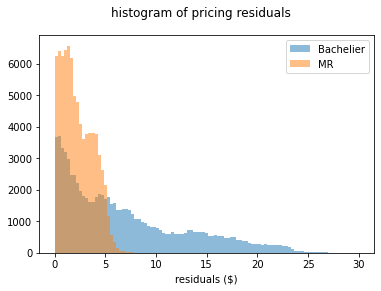

In [70]:
# axis
fig = plt.figure()
ax = plt.gca()
# data
bins = np.linspace(0,30,100)
bachelier = df['error_bachelier'].loc[df.index < covid_cutoff].to_numpy()
MR = df['error_AMR'].loc[df.index < covid_cutoff].to_numpy()
# layout
fig.suptitle('histogram of pricing residuals')
graph = plt.hist(bachelier, bins, alpha=0.5, label='Bachelier')
graph = plt.hist(MR, bins, alpha=0.5, label='MR')
plt.legend()
plt.xlabel('residuals ($)')

### Covid

Text(0.5, 0, 'residuals ($)')

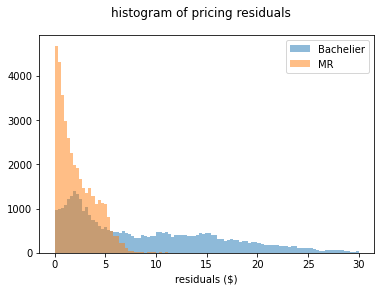

In [71]:
# axis
fig = plt.figure()
ax = plt.gca()
# data
bins = np.linspace(0,30,100)
bachelier = df['error_bachelier'].loc[df.index >= covid_cutoff].to_numpy()
MR = df['error_AMR'].loc[df.index >= covid_cutoff].to_numpy()
# layout
fig.suptitle('histogram of pricing residuals')
graph = plt.hist(bachelier, bins, alpha=0.5, label='Bachelier')
graph = plt.hist(MR, bins, alpha=0.5, label='MR')
plt.legend()
plt.xlabel('residuals ($)')

## Contango vs. Backwardation

Text(0, 0.5, 'price ($/barrel)')

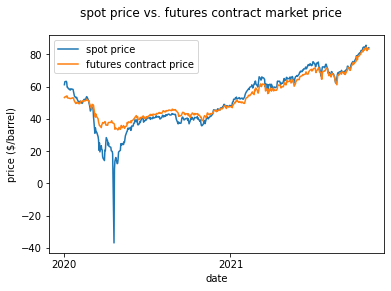

In [189]:
# axis
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[df['symbol'] == 'CLZ21'].loc['2020-01-01':, 'spot'].index)]
spot = df.loc[df['symbol'] == 'CLZ21'].loc['2020-01-01':, 'spot'].to_numpy()
future = df.loc[df['symbol'] == 'CLZ21'].loc['2020-01-01':, 'future'].to_numpy()
# layout
fig.suptitle('spot price vs. futures contract market price')
graph = plt.plot(dates, spot, label='spot price')
graph = plt.plot(dates, future, label='futures contract price')
plt.legend()
plt.xlabel('date')
plt.ylabel('price ($/barrel)')

Text(0, 0.5, 'price ($/barrel)')

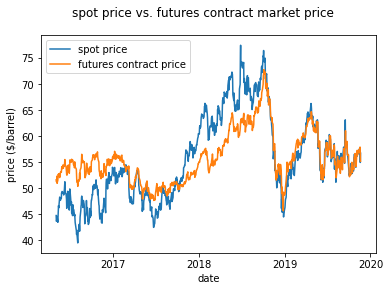

In [190]:
# axis
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# data
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(df.loc[df['symbol'] == 'CLZ19', 'spot'].index)]
spot = df.loc[df['symbol'] == 'CLZ19', 'spot'].to_numpy()
future = df.loc[df['symbol'] == 'CLZ19', 'future'].to_numpy()
# layout
fig.suptitle('spot price vs. futures contract market price')
graph = plt.plot(dates, spot, label='spot price')
graph = plt.plot(dates, future, label='futures contract price')
plt.legend()
plt.xlabel('date')
plt.ylabel('price ($/barrel)')

### Predicting contango and backwardation

In [195]:
df_non_covid = df.loc[df.index < covid_cutoff]
df_covid = df.loc[df.index >= covid_cutoff]

#### Non-Covid Period

In [196]:
# correctly predicted contango for the Bachelier model
mask1 = (df_non_covid['future'] - df_non_covid['spot']) >= 0
mask2 = (df_non_covid['F_hat_bachelier'] - df_non_covid['spot']) >= 0
# correctly predicted contango for the Bachelier model
mask3 = (df_non_covid['future'] - df_non_covid['spot']) < 0
mask4 = (df_non_covid['F_hat_bachelier'] - df_non_covid['spot']) < 0
# total correctly predicted market states
contango =  df_non_covid.loc[(mask1&mask2)].shape[0] / df_non_covid.loc[mask1].shape[0]
backwardation = df_non_covid.loc[(mask3&mask4)].shape[0] / df_non_covid.loc[mask3].shape[0]
both = df_non_covid.loc[(mask1&mask2) | (mask3&mask4)].shape[0] / df_non_covid.shape[0]
# show results
print('market was in contango for: {}'.format(df_non_covid.loc[mask1].shape[0]/df_non_covid.shape[0]))
print('contango correctly: {}'.format(contango))
print('--------------------------------------------')
print('market was in backwardation for: {}'.format(df_non_covid.loc[mask3].shape[0]/df_non_covid.shape[0]))
print('backwardation correctly: {}'.format(backwardation))
print('--------------------------------------------')
print('both correctly: {}'.format(both))

market was in contango for: 0.40644285361639104
contango correctly: 1.0
--------------------------------------------
market was in backwardation for: 0.593557146383609
backwardation correctly: 0.0
--------------------------------------------
both correctly: 0.40644285361639104


In [197]:
# correctly predicted contango for the Mean-Reversion model
mask1 = (df_non_covid['future'] - df_non_covid['spot']) >= 0
mask2 = (df_non_covid['F_hat_AMR'] - df_non_covid['spot']) >= 0
# correctly predicted contango for the Mean-Reversion model
mask3 = (df_non_covid['future'] - df_non_covid['spot']) < 0
mask4 = (df_non_covid['F_hat_AMR'] - df_non_covid['spot']) < 0
# total correctly predicted market states
contango =  df_non_covid.loc[(mask1&mask2)].shape[0] / df_non_covid.loc[mask1].shape[0]
backwardation = df_non_covid.loc[(mask3&mask4)].shape[0] / df_non_covid.loc[mask3].shape[0]
both = df_non_covid.loc[(mask1&mask2) | (mask3&mask4)].shape[0] / df_non_covid.shape[0]
# show results
print('market was in contango for: {}'.format(df_non_covid.loc[mask1].shape[0]/df_non_covid.shape[0]))
print('contango correctly: {}'.format(contango))
print('--------------------------------------------')
print('market was in backwardation for: {}'.format(df_non_covid.loc[mask3].shape[0]/df_non_covid.shape[0]))
print('backwardation correctly: {}'.format(backwardation))
print('--------------------------------------------')
print('both correctly: {}'.format(both))

market was in contango for: 0.40644285361639104
contango correctly: 0.94397206194959
--------------------------------------------
market was in backwardation for: 0.593557146383609
backwardation correctly: 0.8327095030151799
--------------------------------------------
both correctly: 0.8779313749691434


So for the Mean-Reversion model we have a total accuracy of 88%.

#### Covid Period

In [198]:
# correctly predicted contango for the Bachelier model
mask1 = (df_covid['future'] - df_covid['spot']) >= 0
mask2 = (df_covid['F_hat_bachelier'] - df_covid['spot']) >= 0
# correctly predicted contango for the Bachelier model
mask3 = (df_covid['future'] - df_covid['spot']) < 0
mask4 = (df_covid['F_hat_bachelier'] - df_covid['spot']) < 0
# total correctly predicted market states
contango =  df_covid.loc[(mask1&mask2)].shape[0] / df_covid.loc[mask1].shape[0]
backwardation = df_covid.loc[(mask3&mask4)].shape[0] / df_covid.loc[mask3].shape[0]
both = df_covid.loc[(mask1&mask2) | (mask3&mask4)].shape[0] / df_covid.shape[0]
# show results
print('market was in contango for: {}'.format(df_covid.loc[mask1].shape[0]/df_covid.shape[0]))
print('contango correctly: {}'.format(contango))
print('--------------------------------------------')
print('market was in backwardation for: {}'.format(df_covid.loc[mask3].shape[0]/df_covid.shape[0]))
print('backwardation correctly: {}'.format(backwardation))
print('--------------------------------------------')
print('both correctly: {}'.format(both))

market was in contango for: 0.46374536846438863
contango correctly: 1.0
--------------------------------------------
market was in backwardation for: 0.5362546315356114
backwardation correctly: 0.0
--------------------------------------------
both correctly: 0.46374536846438863


In [199]:
# correctly predicted contango for the Mean-Reversion model
mask1 = (df_covid['future'] - df_covid['spot']) > 0
mask2 = (df_covid['F_hat_AMR'] - df_covid['spot']) > 0
# correctly predicted contango for the Mean-Reversion model
mask3 = (df_covid['future'] - df_covid['spot']) < 0
mask4 = (df_covid['F_hat_AMR'] - df_covid['spot']) < 0
# total correctly predicted market states
contango =  df_covid.loc[(mask1&mask2)].shape[0] / df_covid.loc[mask1].shape[0]
backwardation = df_covid.loc[(mask3&mask4)].shape[0] / df_covid.loc[mask3].shape[0]
both = df_covid.loc[(mask1&mask2) | (mask3&mask4)].shape[0] / df_covid.shape[0]
# show results
print('market was in contango for: {}'.format(df_covid.loc[mask1].shape[0]/df_covid.shape[0]))
print('contango correctly: {}'.format(contango))
print('--------------------------------------------')
print('market was in backwardation for: {}'.format(df_covid.loc[mask3].shape[0]/df_covid.shape[0]))
print('backwardation correctly: {}'.format(backwardation))
print('--------------------------------------------')
print('both correctly: {}'.format(both))

market was in contango for: 0.4629477151090984
contango correctly: 0.9721542907959093
--------------------------------------------
market was in backwardation for: 0.5362546315356114
backwardation correctly: 0.8731826687778897
--------------------------------------------
both correctly: 0.9183048579662413


## Samuelson effect

### Non-Covid period

In [200]:
tau_range_non_covid = np.append(np.linspace(0,2,21),np.linspace(2,7,70))

In [201]:
tau_dict_non_covid = {}
for i, tau in enumerate(tau_range_non_covid):
    if i == 0:
        continue
    mask1 = df_non_covid['tau'] <= tau
    mask2 = df_non_covid['tau'] > tau_range_non_covid[i-1]
    tau_dict_non_covid[tau] = df_non_covid.loc[mask1&mask2, ['future', 'spot', 'F_hat_bachelier', 'F_hat_AMR']].std()

In [202]:
samuelson_non_covid = pd.DataFrame.from_dict(tau_dict_non_covid, orient='index', columns = ['future', 'spot', 'F_hat_bachelier', 'F_hat_AMR']).dropna()

Text(0, 0.5, 'std ($)')

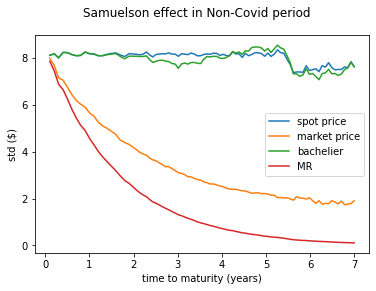

In [203]:
# axis
fig = plt.figure()
ax = plt.gca()
# data
dates = list(samuelson_non_covid.index)
spot = samuelson_non_covid['spot'].to_numpy()
future = samuelson_non_covid['future'].to_numpy()
bachelier = samuelson_non_covid['F_hat_bachelier'].to_numpy()
mr = samuelson_non_covid['F_hat_AMR'].to_numpy()
# layout
fig.suptitle('Samuelson effect in Non-Covid period')
graph = plt.plot(dates, spot, label='spot price')
graph = plt.plot(dates, future, label='market price')
graph = plt.plot(dates, bachelier, label='bachelier')
graph = plt.plot(dates, mr, label='MR')
plt.legend()
plt.xlabel('time to maturity (years)')
plt.ylabel('std ($)')

## Covid Period

In [204]:
tau_range_covid = np.append(np.linspace(0,2,21),np.linspace(2,7,70))

In [205]:
tau_dict_covid = {}
for i, tau in enumerate(tau_range_covid):
    if i == 0:
        continue
    mask1 = df_covid['tau'] <= tau
    mask2 = df_covid['tau'] > tau_range_covid[i-1]
    tau_dict_covid[tau] = df_covid.loc[mask1&mask2, ['future', 'spot', 'F_hat_bachelier', 'F_hat_AMR']].std()

In [206]:
samuelson_covid = pd.DataFrame.from_dict(tau_dict_covid, orient='index', columns = ['future', 'spot', 'F_hat_bachelier', 'F_hat_AMR']).dropna()

Text(0, 0.5, 'std ($)')

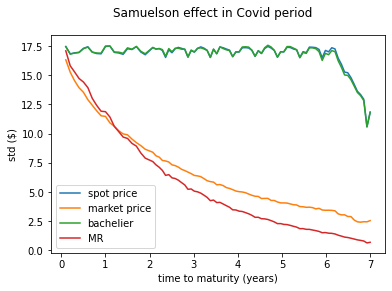

In [207]:
# axis
fig = plt.figure()
ax = plt.gca()
# data
dates = list(samuelson_covid.index)
spot = samuelson_covid['spot'].to_numpy()
future = samuelson_covid['future'].to_numpy()
bachelier = samuelson_covid['F_hat_bachelier'].to_numpy()
mr = samuelson_covid['F_hat_AMR'].to_numpy()
# layout
fig.suptitle('Samuelson effect in Covid period')
graph = plt.plot(dates, spot, label='spot price')
graph = plt.plot(dates, future, label='market price')
graph = plt.plot(dates, bachelier, label='bachelier')
graph = plt.plot(dates, mr, label='MR')
plt.legend()
plt.xlabel('time to maturity (years)')
plt.ylabel('std ($)')

Samuelson effect gives preference to the Mean-Reversion model. How to explain the behaviour of the Bachelier model?

## Mean-Reversion character of market

Text(0, 0.5, 'price ($)')

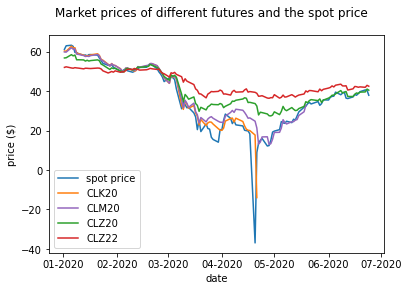

In [208]:
combined = df.loc[(df.index > '2020-01-01') & (df.index < '2020-06-25')]
# axis
symbol = 'CLZ20'
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
# data
spot = combined.loc[(combined['symbol'] == symbol), 'spot'].to_numpy()
dates_spot = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(combined.loc[(combined['symbol'] == symbol)].index)]

K20 = combined.loc[(combined['symbol'] == 'CLK20'), 'future'].to_numpy()
dates = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(combined.loc[(combined['symbol'] == 'CLK20')].index)]

M20 = combined.loc[(combined['symbol'] == 'CLM20'), 'future'].to_numpy()
dates1 = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(combined.loc[(combined['symbol'] == 'CLM20')].index)]

Z20 = combined.loc[(combined['symbol'] == 'CLZ20'), 'future'].to_numpy()
dates2 = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(combined.loc[(combined['symbol'] == 'CLZ20')].index)]

Z22 = combined.loc[(combined['symbol'] == 'CLZ22'), 'future'].to_numpy()
dates3 = [matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d'))  for x in list(combined.loc[(combined['symbol'] == 'CLZ22')].index)]

# layout
fig.suptitle("Market prices of different futures and the spot price")
plt.plot(dates_spot, spot, label='spot price', color='tab:blue')
plt.plot(dates, K20, label='CLK20', color='tab:orange')
plt.plot(dates1, M20, label='CLM20', color='tab:purple')
plt.plot(dates2, Z20, label='CLZ20', color='tab:green')
plt.plot(dates3, Z22, label='CLZ22', color='tab:red')
plt.legend()
plt.xlabel('date')
plt.ylabel("price ($)")

We can cleary see that as time to maturity increases, the market price seems to revert back to a long term averge. Goes well with the idea behind mean reversion.